In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['seg_train', 'seg_pred', 'seg_test']


In [2]:
!ls ../input

seg_pred  seg_test  seg_train


In [3]:
import torch
from torch import nn
from torchvision import datasets, models, transforms


In [4]:
import torch.utils.data as tdata

In [5]:
!ls ../input/seg_train/seg_train/
!ls ../input/seg_test/seg_test/

buildings  forest  glacier  mountain  sea  street
buildings  forest  glacier  mountain  sea  street


In [6]:
data_path_format = '../input/seg_{0}/seg_{0}'

In [7]:
np.random.seed(5315)
torch.manual_seed(9784)

In [8]:
# channel_means = (0.4301, 0.4572, 0.4540)
# channel_stds = (0.2698, 0.2680, 0.2983)  # 0.485, 0.456, 0.406
channel_means = (0.485, 0.456, 0.406)
channel_stds = (0.229, 0.224, 0.225)

In [9]:
image_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(channel_means, channel_stds)
])
    

In [10]:
image_datasets = dict(zip(('dev', 'test'), [datasets.ImageFolder(data_path_format.format(key),transform=image_transforms) for key in ['train', 'test']]))
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root Location: ../input/seg_train/seg_train
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root Location: ../input/seg_test/seg_test
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None}


In [11]:
devset_indices = np.arange(len(image_datasets['dev']))
devset_labels = image_datasets['dev'].targets

In [12]:
from sklearn import model_selection

In [13]:
train_indices, val_indices, train_labels,  val_labels = model_selection.train_test_split(devset_indices, devset_labels, test_size=0.1, stratify=devset_labels)

In [14]:
print(len(val_indices))

1404


In [15]:
image_datasets['train'] = tdata.Subset(image_datasets['dev'], train_indices)
image_datasets['validation'] = tdata.Subset(image_datasets['dev'], val_indices)

In [16]:
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root Location: ../input/seg_train/seg_train
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root Location: ../input/seg_test/seg_test
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'train': <torch.utils.data.dataset.Subset object at 0x7f05653d4fd0>, 'validation': <torch.utils.data.dataset.Subset object at 0x7f05653d4f98>}


In [17]:
from IPython.display import display

In [18]:
image_dataloaders = {key: tdata.DataLoader(image_datasets[key], batch_size=16,shuffle=True) for key in  ['train', 'validation']}

In [19]:
image_dataloaders['test'] = tdata.DataLoader(image_datasets['test'], batch_size=32)

In [20]:
def imshow(inp, title=None, fig_size=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # C x H x W  # H x W x C
    inp = channel_stds * inp + channel_means
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot('111')
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.set_aspect('equal')
    plt.pause(0.001)  

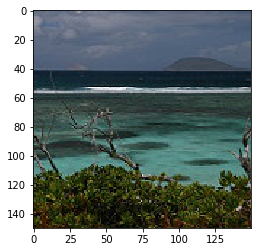

In [21]:
imshow(image_datasets['train'][8555][0]) # 5946

In [22]:
cuda_device = torch.device('cuda')
cpu_device = torch.device('cpu')
device = cuda_device

In [23]:
class task5Net(torch.nn.Module):
    
    #Отдельные методы класса для инициализации слоёв
    def layer(self, input_, output_, kernel_size):   
        return nn.Sequential(torch.nn.Conv2d(input_, output_, kernel_size, padding=1), torch.nn.ReLU(), torch.nn.BatchNorm2d(output_), torch.nn.MaxPool2d(2, 2))
    
    def layer_lin(self, input_, output_):
        return nn.Sequential(torch.nn.Linear(input_, output_))
    
    def __init__(self):
        
        super(task5Net, self).__init__()
        
        #Начальные параметры входа и выхода
        input_ = 3  #RGB
        output_ = 10
        
        end_lin = 6  #Количество классов для распознавания
        
        #Размер перемещающейся по изображению свёртки (3x3)
        kernel_size = 3
        
        #Инициализация слоёв
        
        self.layer1 = self.layer(input_, output_, kernel_size)
        #Вход следующего слоя равен выходу предыдущего
        input_ = output_
        #Увеличение выхода в два раза для следующего слоя
        output_ = output_ * 2
        
        self.layer2 = self.layer(input_, output_, kernel_size)
        input_ = output_
        output_ = output_ * 2
        
        self.layer3 = self.layer(input_, output_, kernel_size)
        input_ = output_
        output_ = output_ * 2
        
        self.layer4 = self.layer(input_, output_, kernel_size)
        input_ = output_
        output_ = output_ * 2
        
        self.layer5 = self.layer(input_, output_, kernel_size)
        input_ = output_
        output_ = output_ * 2
        
        self.layer6 = self.layer(input_, output_, kernel_size)
        input_ = output_
        output_ = output_ * 2
        
        self.layer7 = self.layer(input_, output_, kernel_size)
        
        #Обратно (но деление на 4)
        input_ = output_
        output_ = output_ // 4
    
        #Линейные преобразования
        self.fc1 = self.layer_lin(input_, output_)
        input_ = output_
        output_ = output_ // 4
        
        self.fc2 = self.layer_lin(input_, output_)
        input_ = output_
        output_ = output_ // 4
        
        self.fc3 = self.layer_lin(input_, output_)
        
    def forward(self, x):
        
        x = nn.Sequential(self.layer1)(x)
        x = nn.Sequential(self.layer2)(x)
        x = nn.Sequential(self.layer3)(x)
        x = nn.Sequential(self.layer4)(x) 
        x = nn.Sequential(self.layer5)(x) 
        x = nn.Sequential(self.layer6)(x)
        x = nn.Sequential(self.layer7)(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = nn.Sequential(self.fc1)(x)
        x = nn.Sequential(self.fc2)(x)
        x = nn.Sequential(self.fc3)(x)
        
        return x
    
ptr = task5Net()
ptr = ptr.to(device)

In [24]:
class BestModel:
    def __init__(self, path, initial_criterion):
        self.path = path
        self.criterion = initial_criterion
        
    def update(self, model, optimizer, criterion):
        self.criterion = criterion
        torch.save({'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict(), 'criterion': criterion}, self.path)
        
    def load_model_data(self):
        return torch.load(self.path)
    
    def restore(self, model, optimizer):
        model_data = self.load_model_data()
        model.load_state_dict(model_data['model_state'])
        optimizer.load_state_dict(model_data['optimizer_state'])

In [25]:
def train_model(epochs, model, optimizer, criterion, loaders, device, best_model, n_prints=1):
    print_every = len(loaders['train']) // n_prints
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        for iteration, (xx, yy) in enumerate(loaders['train']):
            optimizer.zero_grad()
            xx, yy = xx.to(device), yy.to(device)
            out = model(xx)
            loss = criterion(out, yy)
            running_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if(iteration % print_every == print_every - 1):
                running_train_loss /= print_every
                print(f"Epoch {epoch}, iteration {iteration} training_loss {running_train_loss}")
                running_train_loss = 0.0
            
        with torch.no_grad():
            model.eval()
            running_corrects = 0
            running_total = 0
            running_loss = 0.0
            for xx, yy in loaders['validation']:
                batch_size = xx.size(0)
                xx, yy = xx.to(device), yy.to(device)

                out = model(xx)
                
                loss = criterion(out, yy)
                running_loss += loss.item()
                
                predictions = out.argmax(1)
                running_corrects += (predictions == yy).sum().item()
                running_total += batch_size
            
            mean_val_loss = running_loss / len(loaders['validation'])
            accuracy = running_corrects / running_total
            
            if accuracy > best_model.criterion:
                best_model.update(model, optimizer, accuracy)
            
            print(f"Epoch {epoch}, val_loss {mean_val_loss}, accuracy = {accuracy}")
    best_model.restore(model, optimizer)
                
                

In [26]:
import time
start = time.time()

In [27]:
optimizer = torch.optim.Adam(ptr.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()
best_model = BestModel('resnet_data',0.0)
train_model(20, ptr, optimizer, criterion,image_dataloaders, device, best_model=best_model, n_prints=5)

Epoch 0, iteration 157 training_loss 1.0953953266143799
Epoch 0, iteration 315 training_loss 0.8662365948474859
Epoch 0, iteration 473 training_loss 0.7608817472488065
Epoch 0, iteration 631 training_loss 0.7229573403166819
Epoch 0, iteration 789 training_loss 0.6363221894525275
Epoch 0, val_loss 0.5167370079593225, accuracy = 0.8062678062678063
Epoch 1, iteration 157 training_loss 0.549793217001082
Epoch 1, iteration 315 training_loss 0.6074657191204119
Epoch 1, iteration 473 training_loss 0.5825206007384047
Epoch 1, iteration 631 training_loss 0.5651007722827452
Epoch 1, iteration 789 training_loss 0.5366630534393878
Epoch 1, val_loss 0.5032514713027261, accuracy = 0.8212250712250713
Epoch 2, iteration 157 training_loss 0.49237029801441146
Epoch 2, iteration 315 training_loss 0.479216988988315
Epoch 2, iteration 473 training_loss 0.4739487754015983
Epoch 2, iteration 631 training_loss 0.4776168379791175
Epoch 2, iteration 789 training_loss 0.4369771476787857
Epoch 2, val_loss 0.43431

In [28]:
end = time.time()
print(end - start)

707.7849748134613


In [29]:
from torchvision.utils import make_grid

In [30]:
xx, yy = next(iter(image_dataloaders['validation']))

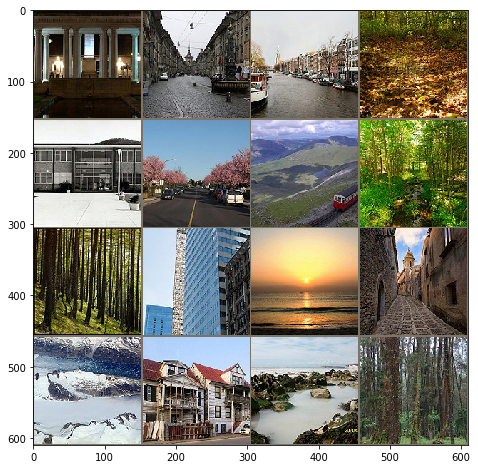

['forest', 'street', 'street', 'forest', 'buildings', 'street', 'mountain', 'forest', 'forest', 'buildings', 'sea', 'street', 'glacier', 'buildings', 'mountain', 'forest']
['buildings', 'street', 'street', 'forest', 'buildings', 'street', 'mountain', 'forest', 'forest', 'buildings', 'sea', 'street', 'glacier', 'buildings', 'sea', 'forest']


In [31]:
ptr.eval()
out = ptr(xx.cuda())
preds = out.argmax(1)
predicted_classes = [image_datasets['dev'].classes[c] for c in preds]
actual_classes = [image_datasets['dev'].classes[c] for c in yy]
imshow(make_grid(xx, nrow=4), fig_size=(8,8))
print(predicted_classes)
print(actual_classes)

In [32]:
all_preds = []
correct_preds = []
with torch.no_grad():
    ptr.eval()
    for xx, yy in image_dataloaders['test']:
        xx = xx.to(device)
        output = ptr(xx)
        all_preds.extend(output.argmax(1).tolist())
        correct_preds.extend(yy.tolist())

In [33]:
from sklearn import metrics

In [34]:
all_preds = np.asarray(all_preds)
correct_preds = np.asarray(correct_preds)

In [35]:
target_names = image_datasets['test'].classes
print(metrics.classification_report(correct_preds, all_preds,target_names=target_names))

              precision    recall  f1-score   support

   buildings       0.87      0.80      0.83       437
      forest       0.93      0.98      0.95       474
     glacier       0.91      0.61      0.73       553
    mountain       0.70      0.90      0.79       525
         sea       0.83      0.88      0.86       510
      street       0.87      0.88      0.87       501

   micro avg       0.84      0.84      0.84      3000
   macro avg       0.85      0.84      0.84      3000
weighted avg       0.85      0.84      0.84      3000



In [36]:
confusion_matrix = metrics.confusion_matrix(correct_preds, all_preds)
pd.DataFrame(confusion_matrix, index=target_names, columns=target_names)

,buildings,forest,glacier,mountain,sea,street
buildings,350,5,1,9,16,56
forest,2,463,1,5,1,2
glacier,5,7,336,161,37,7
mountain,4,3,15,471,32,0
sea,8,6,16,25,451,4
street,34,14,2,4,4,443
